# Compulsory Assignment 2: Convolutional neural networks

Please fill out the group name, number, members and optionally the name below.

**Group number**: \
**Group member 1**: \
**Group member 2**: \
**Group member 3**: \
**Group name (optional)**:

Make sure that the group name given in the assignment is the same that you use on the Kaggle Leaderboard.

# Assignment Submission
To complete this assignment answer the relevant questions in this notebook and write the code required to implement the relevant models. The assignment is submitted by handing in this notebook as an .ipynb file and as a .pdf file. In addition, you are required to submit at least one test prediction to the Kaggle leaderboard that is better than the *BEAT ME* score. And, for fun see if you can beat the BONUS BENCHMARK submission score.

NOTE: Remember to go through the rules given in the lecture "Introduction to compulsory assignments", as there are many do's and dont's with regard to how you should present the work you are going to submit.

# Introduction
This assignment will start with classifying handwritten digits from the MNIST dataset, used in the voluntary assignment and the first compulsory assignment. The second part of this task will revolve around classifying the open-source Fashion-MNIST.



## Fashion-MNIST

The Fashion-MNIST is a dataset created from Zalando's article images(https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md). The dataset consists of 70,000 labels images in 28x28 grayscale image labeled from 0 to 10. The goal of the Fashion-MNIST to work as a harder version of the handletter dataset MNIST. The Github repo for the dataset describe the dataset to be:
- "intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms."


<center><img src="fashion-mnist-sprite.png" width="500" height="400"></center>


## Assignment structure

1. Part 1: Implementing LeNet??? for classifying MNIST.
2. Part 2: Designing your own CNN for classifying Fashion-MNIST

## Submissions to the Kaggle leaderboard
Use the following code to create the `submission.csv` file that you can submit to the Kaggle leaderboard.

```python
prediction = model.predict(X_test)
flat_prediction = np.argmax(prediction, axis=1) # Flatten softmax predictions
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_prediction)) # The submission csv file must have an row index column called 'ID'
submissionDF['Prediction'] = flat_prediction
submissionDF.to_csv('submission.csv', index=False) # Remember to store the dataframe to csv without the nameless index column.
```

## Library imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())


/content


In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/DAT300/Template")

In [ ]:
!pip install tensorflow
!pip install tensorflow.keras
!pip install scikeras



ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras


In [ ]:
# Feel free to add or remove libraries as you want
import time
from tqdm import tqdm # Cool progress bar

import numpy as np
import pandas as pd
import h5py
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV





import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras as ks
from keras import layers, models
from scikeras.wrappers import KerasClassifier, KerasRegressor



SEED = 458
RNG = np.random.default_rng(SEED) # Random number generator

from utilities import *

# Part 1: CNN for classifying the MNIST dataset

## Loading MNIST

In [ ]:
datasets = load_mnist(verbose=0)
X_train, y_train = datasets['X_train'], datasets['y_train']
X_val,   y_val   = datasets['X_val'],   datasets['y_val']
X_test,  y_test  = datasets['X_test'],  datasets['y_test']

X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0).astype('int32')

del datasets, X_val, y_val # Good to reduce uneccesary RAM usage

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Preprocessing

In [ ]:
# Reshape data to account for color channel
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

# Normalizing input between [0,1]
X_train = X_train.astype("float32")/np.max(X_train)
X_test  = X_test.astype("float32")/np.max(X_test)

# Converting targets from numbers to categorical format
y_train = ks.utils.to_categorical(y_train, len(np.unique(y_train)))
y_test  = ks.utils.to_categorical(y_test, len(np.unique(y_test)))

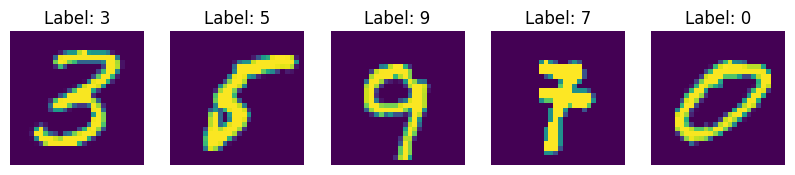

In [ ]:
def plot_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28))
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()

plot_images(X_train, y_train, num_images=5)

## Task 1.1: Build a CNN network with the LeNet5 architecture

##### Implement LeNet5 architecture according to the following specifications:

--------------------------
The LeNet architecture takes a 28x28xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

**Layer 1 - Convolution (5x5):** The output shape should be 28x28x6. **Activation:** ReLU.

**MaxPooling:** The output shape should be 14x14x6.

**Layer 2 - Convolution (5x5):** The output shape should be 10x10x16. **Activation:** ReLU.

**MaxPooling:** The output shape should be 5x5x16.

**Flatten:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.  You may need to use tf.reshape.

**Layer 3 - Fully Connected:** This should have 120 outputs. **Activation:** ReLU.

**Layer 4 - Fully Connected:** This should have 84 outputs. **Activation:** ReLU.

**Layer 5 - Fully Connected:** This should have 10 outputs. **Activation:** softmax.

--------------------------


##### Compile the network with the
* `tf.keras.losses.CategoricalCrossentropy` loss function
* the `adam` optimizer
* with the `accuracy` metric and (your own implementation of the) F1-score metric.

In [ ]:
def LeNet5():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),  # Input shape with grayscale channel
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',  # Use CategoricalCrossentropy for classification
                  metrics=['accuracy', F1Score()])  # Custom F1Score instantiated, need to implement

    return model

In [ ]:
# Custom F1 Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast y_true to int and y_pred to float for comparison
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.argmax(y_pred, axis=1)
        y_pred = tf.cast(tf.one_hot(y_pred, depth=tf.shape(y_true)[1]), tf.int32)

        # Calculate true positives, false positives, and false negatives
        tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

        # Update internal variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate precision and recall
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        # Calculate F1 score, wiht epsilon to avoid 0 division
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        # Reset all variables to zero
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)

### Task 1.1.2 Train network

Train the network with a
* batch size of 64 samples
* for 20 epochs
* 1/8 validation split

In [ ]:
model = LeNet5()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

test_loss, test_acc, test_f1 = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test F1-score: {test_f1}')

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8644 - f1_score: 0.8644 - loss: 0.4750 - val_accuracy: 0.9746 - val_f1_score: 0.9746 - val_loss: 0.0726
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9802 - f1_score: 0.9802 - loss: 0.0631 - val_accuracy: 0.9825 - val_f1_score: 0.9825 - val_loss: 0.0504
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9850 - f1_score: 0.9850 - loss: 0.0477 - val_accuracy: 0.9871 - val_f1_score: 0.9871 - val_loss: 0.0376
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9889 - f1_score: 0.9889 - loss: 0.0362 - val_accuracy: 0.9877 - val_f1_score: 0.9877 - val_loss: 0.0383
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9905 - f1_score: 0.9905 - loss: 0.0291 - val_accuracy: 0.9905 - val_f1_score: 0.9905 - val_loss: 0.0304
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9929 - f1_score: 0.9929 - loss: 0.0221 - val_accuracy: 0.9880 - val_f1_score: 0.98

## Task 1.2 Evaluaiton
### Task 1.2.1 Plot training history and evaluate on test dataset

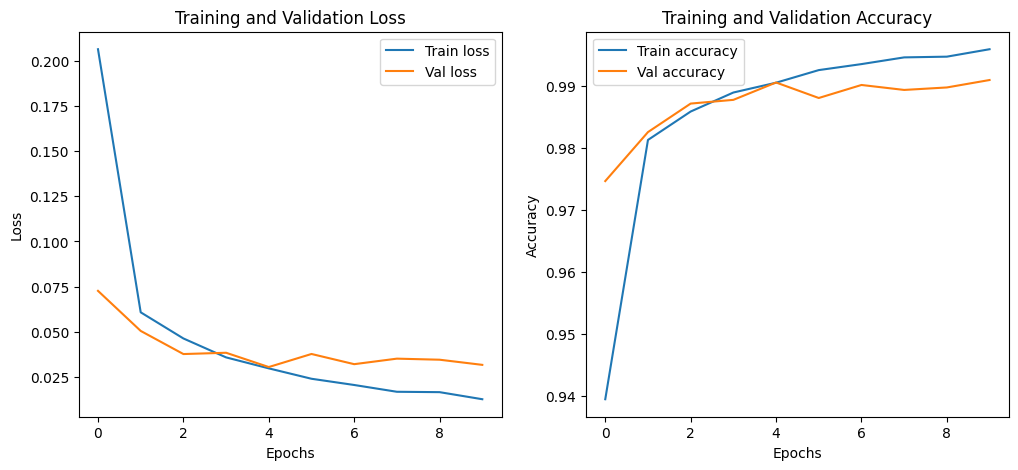

In [ ]:
def plot_training_history(history, metrics):
    plt.figure(figsize=(12, 5))

    for metric in metrics:
        plt.subplot(1, len(metrics), metrics.index(metric) + 1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.legend()

    plt.show()

plot_training_history(history, ['loss', 'accuracy'])

Here it looks like we have overfitted after three epochs, as the training performance keeps getting better, but the validation results stay the same/get a bit worse after this.

### Task 1.2.2 Evaluate on the test dataset

In [ ]:
test_loss, test_acc, test_f1 = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test F1-Score: {test_f1}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9894 - f1_score: 0.9894 - loss: 0.0401
Test Loss: 0.03163137659430504, Test Accuracy: 0.9908999800682068, Test F1-Score: 0.990899920463562


### Task 2.2.3 Create a confution matrix for both traing and testing data
- Does the test data and train data predikt the same items wrong?

In [ ]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def create_confusion_matrices(model, X_train, y_train, X_test, y_test, labels):
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_test_pred = np.argmax(model.predict(X_test), axis=1)

    # Convert one-hot encoded labels back to categorical
    y_train_true = np.argmax(y_train, axis=1)
    y_test_true = np.argmax(y_test, axis=1)

    # Create confusion matrices
    cm_train = confusion_matrix(y_train_true, y_train_pred)
    cm_test = confusion_matrix(y_test_true, y_test_pred)

    # Plot confusion matrices
    print("Confusion Matrix for Training Data:")
    plot_confusion_matrix(cm_train, labels)

    print("Confusion Matrix for Testing Data:")
    plot_confusion_matrix(cm_test, labels)

    return y_train_true, y_train_pred, y_test_true, y_test_pred

# Function to compare errors
def compare_errors(y_train_true, y_train_pred, y_test_true, y_test_pred):
    # Get indices where predictions are incorrect for both training and testing data
    train_errors = np.where(y_train_true != y_train_pred)[0]
    test_errors = np.where(y_test_true != y_test_pred)[0]

    print(f"Number of incorrect predictions in training data: {len(train_errors)}")
    print(f"Number of incorrect predictions in testing data: {len(test_errors)}")

    # Check if any of the same indices are wrong in both train and test
    common_errors = np.intersect1d(train_errors, test_errors)

    print(f"Number of common incorrect predictions in both training and testing data: {len(common_errors)}")
    return common_errors


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix for Training Data:


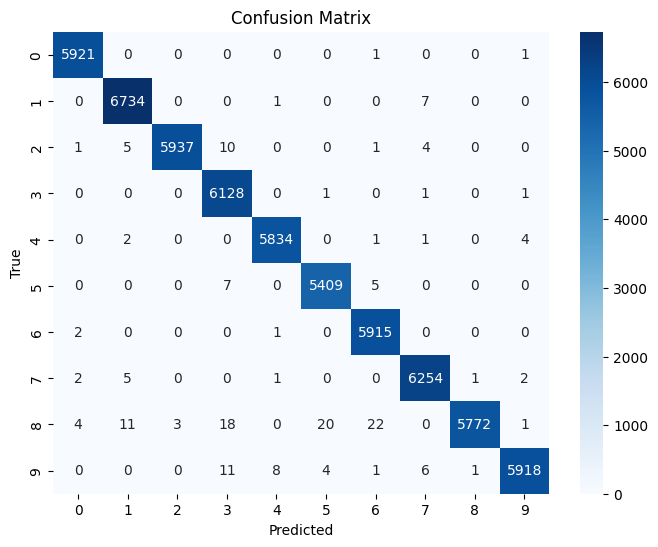

Confusion Matrix for Testing Data:


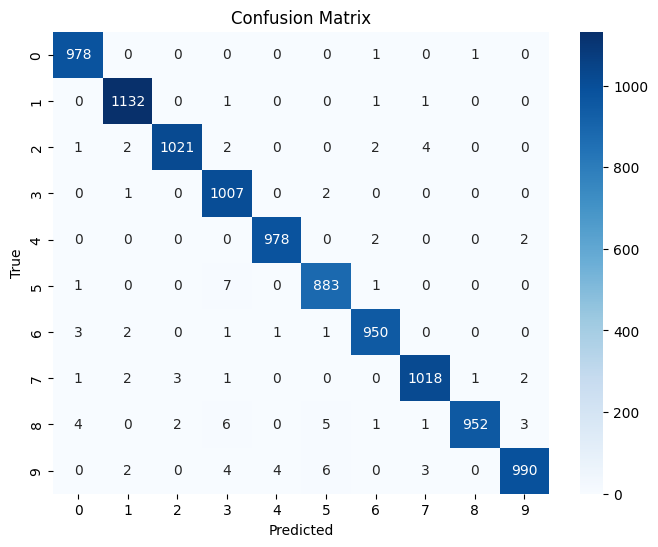

Number of incorrect predictions in training data: 178
Number of incorrect predictions in testing data: 91
Number of common incorrect predictions in both training and testing data: 0


In [ ]:
labels = [str(i) for i in range(10)]

y_train_true, y_train_pred, y_test_true, y_test_pred = create_confusion_matrices(
    model, X_train, y_train, X_test, y_test, labels)

# Compare errors between training and testing data
common_errors = compare_errors(y_train_true, y_train_pred, y_test_true, y_test_pred)

## Task 2.3: MNIST discussion

**Task 2.3.1: What is overfitting and how does it occur during training of the LeNet-5 model**

**Task 2.3.2: What is ReLU and Leaky ReLU, what is their derivative and how does their derivative solve the vanishing gradient problem?**

**Task 2.3.3: Calculate the numbers of weight and the output shape for the LeNet-5 at each layer, Show calculation**

# Task 2: CNN for classifying the Fashion-MNIST dataset

In this task you shall implement a CNN model, and train it to classify the images in the Fashion-MNIST dataset.

## Importing Fashion-MNIST

- Filename: `Fashion_MNIST.h5`

In [ ]:
FILE_PATH = "Fashion_MNIST.h5"

labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [ ]:
with h5py.File(FILE_PATH,'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_train = np.asarray(f['train_images'])
    y_train = np.asarray(f['train_labels'])
    X_test  = np.asarray(f['test_images'])
    # y_test = np.asarray(f['test_labels']) # Datasets in file: ['test_images', 'train_images', 'train_labels'] this doesnt exist, so need to make our own y test
    print('Nr. train images: %i'%(X_train.shape[0]))
    print('Nr. test images: %i'%(X_test.shape[0]))

Datasets in file: ['test_images', 'train_images', 'train_labels']
Nr. train images: 59500
Nr. test images: 10500


## Task 2.1: Preprocess the data
Preprocess the data as you see fit

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1)  # Shape should be (59500, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)     # and (10500, 28, 28, 1)

# Normalize
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Step 3: Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# one hot encoding
y_train = ks.utils.to_categorical(y_train, 10)  # Shape (train_samples, 10)
y_val = ks.utils.to_categorical(y_val, 10)      # Shape (val_samples, 10)

# Print dataset shapes to confirm preprocessing
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")  # Should be (10500, 28, 28, 1)


X_train shape: (47600, 28, 28, 1)
y_train shape: (47600, 10)
X_val shape: (11900, 28, 28, 1)
y_val shape: (11900, 10)
X_test shape: (10500, 28, 28, 1)


## Task 2.2: Visualize the dataset
Plot a few samples images and the distrbution of classes in the data.

In [ ]:
def plot_sample_images(X, y, labels, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X[i].reshape(28, 28))
        plt.title(labels[np.argmax(y[i])])  # Find the label using the one-hot encoded y
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_class_distribution(y, labels, title=None):
    # Convert one-hot back to integers
    y_int = np.argmax(y, axis=1)

    # Count the occurrences of each class
    unique, counts = np.unique(y_int, return_counts=True)

    data = {'Class': [labels[i] for i in unique], 'Count': counts}

    # Plot the distribution using a barplot without specifying the palette, as this was wonkey
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Count', data=pd.DataFrame(data))
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    if title:
        plt.title(title)
    else:
        plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
plot_sample_images(X_train, y_train, labels, num_images=9)

plot_class_distribution(y_train, labels, title="y train dataset distribution")

plot_class_distribution(y_test, labels, title="y TEST dataset distribution")

NameError: name 'plot_sample_images' is not defined

See we have a pretty even distribution of the different items, which is good when training the model, so the model learns better to distinguish different items, and not just a few.

## Task 2.3: Build a CNN for classifying the Fashion-MNIST dataset
Build a CNN model and beat the beat me score on kaggel
- Experiment with different, Kernel sizes, stride, type/number of layers.
- Don't overcomplicate and use it as grounds for discussion.
- Tips, when you make changes to improve the model, save some earlier iterations.
- Only one model score higher than beat me.

In [ ]:
def cnn_model():
    model = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Add Dropout to reduce overfitting, as we saw signs of this earlier
        layers.Dropout(0.25),  # 25% of the units will be dropped out

        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.50),  # 50% dropout after fully connected layer

        # Output Layer, 10 units for classification
        layers.Dense(10, activation='softmax')  # Softmax for multi-class classification
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
cnn_model = cnn_model()
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model
val_loss, val_acc = cnn_model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6616 - loss: 0.9259 - val_accuracy: 0.8371 - val_loss: 0.4302
Epoch 2/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8413 - loss: 0.4395 - val_accuracy: 0.8733 - val_loss: 0.3342
Epoch 3/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8691 - loss: 0.3628 - val_accuracy: 0.8908 - val_loss: 0.2915
Epoch 4/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8822 - loss: 0.3228 - val_accuracy: 0.8990 - val_loss: 0.2745
Epoch 5/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8926 - loss: 0.2965 - val_accuracy: 0.9003 - val_loss: 0.2699
Epoch 6/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9007 - loss: 0.2689 - val_accuracy: 0.9010 - val_loss: 0.2606
Epoch 7/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9061 - loss: 0.2599 - val_accuracy: 0.9068 - val_loss: 0.2518
Epoch 8/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9140 - loss: 0.2405 - val_accuracy: 0

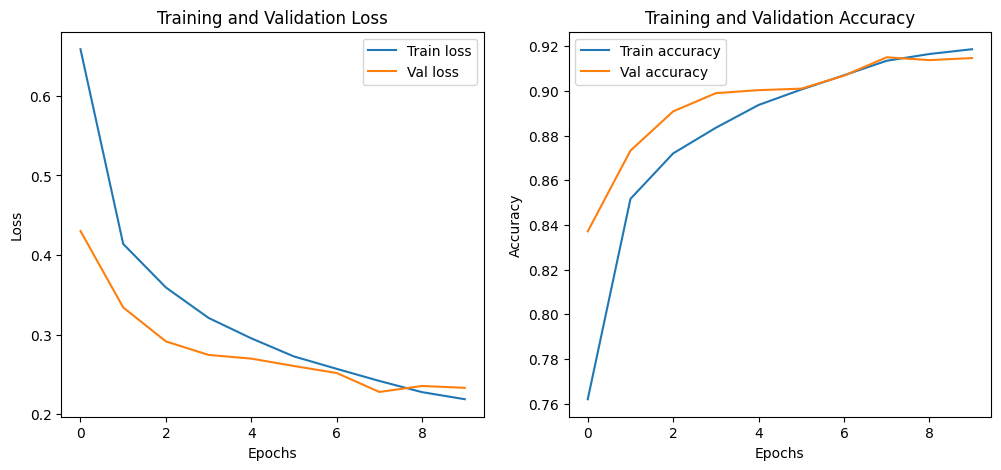

In [ ]:
plot_training_history(history, ['loss', 'accuracy'])

Want to run it with param grid to see what works best. First i made a complete grid, but found out later that randomsearch is just easier and more efficient, but keep this structure to plot and see the performance over time later on, of just the few best models. Then got a very bad result as the best one from randomsearch, so went back to gridsearch

In [ ]:
def cnn_model(filters, kernel_size, dropout_rate, dense_units, extra_layer):
    model = models.Sequential()

    # First set of layers
    model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(28, 28, 1), padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second set of layers
    model.add(layers.Conv2D(filters=filters * 2, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout_rate))

    # Add extra layer if specified
    if extra_layer:
        model.add(layers.Conv2D(filters=filters * 4, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def plot_all_model_performance(histories, model_configs, metric):
    plt.figure(figsize=(10, 6))

    # Plot the performance for each model
    for i, history in enumerate(histories):
        val_metric = f'val_{metric}'
        plt.plot(history.history[val_metric], label=f'Model {i+1}: {model_configs[i]}')

    plt.title(f'Validation {metric.capitalize()} for Different Models')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

In [ ]:
param_grid = {
    'filters': [64, 128],  # in the making of the model, 32 means 32 for the first, then 64, 128 and 128 in the last one if there is an extra layer
    'kernel_size': [(5, 5)],
    'dropout_rate': [0.5],
    'dense_units': [256],
    'extra_layer': [True]
}

In [ ]:
histories = []
model_configs = []

best_model = None
best_accuracy = 0

# Loop through each combination of hyperparameters
for params in ParameterGrid(param_grid):
    print(f"Testing model with params: {params}")

    # Build and train model with the current set of parameters
    model = cnn_model(filters=params['filters'],
                      kernel_size=params['kernel_size'],
                      dropout_rate=params['dropout_rate'],
                      dense_units=params['dense_units'],
                      extra_layer=params['extra_layer'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val), verbose=0)

    # Store the training history and model configuration
    histories.append(history)
    model_configs.append(params)

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_accuracy}")

    # Track the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model

print(f"Best Validation Accuracy: {best_accuracy}")

Testing model with params: {'dense_units': 256, 'dropout_rate': 0.5, 'extra_layer': True, 'filters': 64, 'kernel_size': (5, 5)}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.9175630211830139
Testing model with params: {'dense_units': 256, 'dropout_rate': 0.5, 'extra_layer': True, 'filters': 128, 'kernel_size': (5, 5)}
Validation Accuracy: 0.9226890802383423
Best Validation Accuracy: 0.9226890802383423


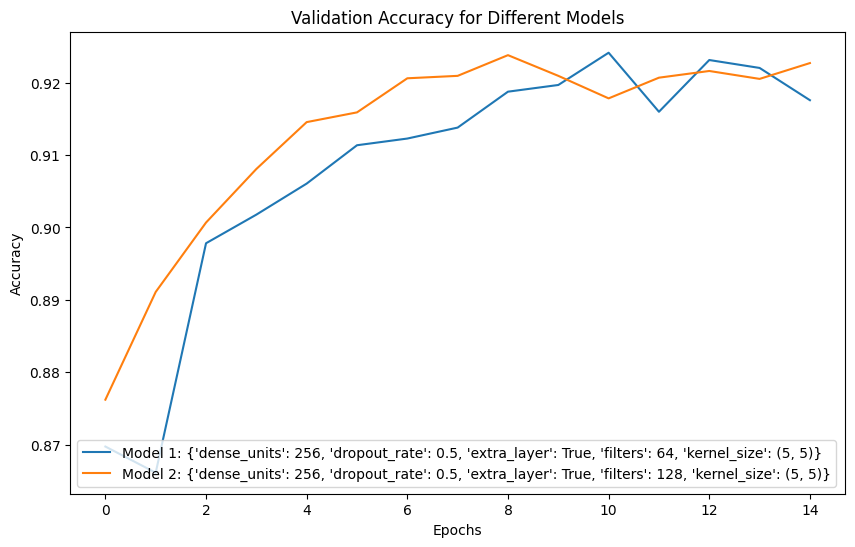

In [ ]:
plot_all_model_performance(histories, model_configs, 'accuracy')

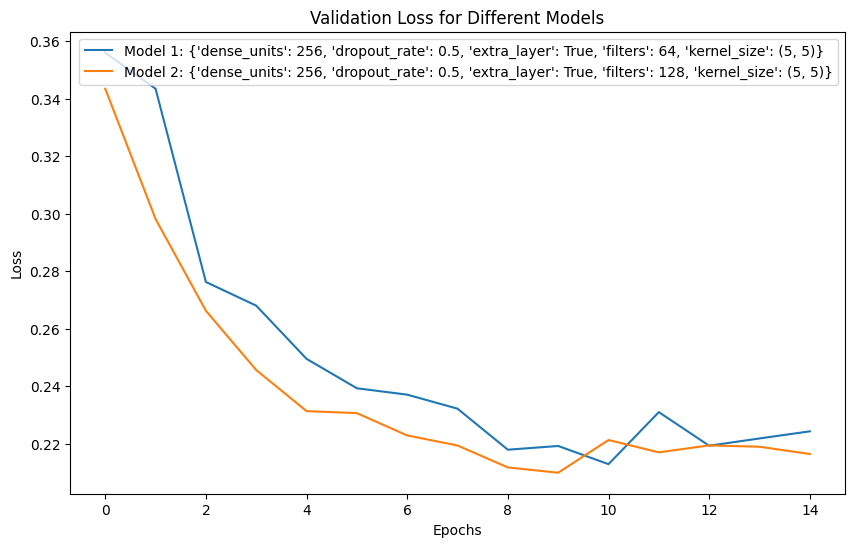

In [ ]:
plot_all_model_performance(histories, model_configs, 'loss')

Seems like the 7th model has the lowest loss and good performance as well. Depending on the runs, but seems like 256, 0.3, True, 64, (5, 5) is a pretty good param combination. Had better performance on kaggle after 10 than 15 epochs, probably because of overfitting, even if it might not show here, with only 10% of the data as validation. Try again with higher dropout rate, 0.5 instead of 0.3 to prevent overfitting. This got the best model so far on our validation set, with an val acc of ...

In [ ]:
# save best model:
best_model.save('best_model.keras')

Saw bigger kernel size, had a bit better performance, generally, 5x5 over 3x3, so maybe try out with different sized kernels in the future. more filters as well had a bit better performance. Tried with 7x7, and seemed to be worse than 5x5, but also looks like it needs more epochs to finish training. try again with 10 epochs.



## Task 2.4: Evaluate your best model on the test dataset and submit your prediction to the Kaggle leaderboard

In [ ]:
from tensorflow.keras.models import load_model
Kaggle_model = load_model('best_model.keras')


In [ ]:
Kaggle_model_prediction = Kaggle_model.predict(X_test)
flat_Kaggle_model_prediction_prediction = np.argmax(Kaggle_model_prediction, axis=1)
submissionKaggle = pd.DataFrame()
submissionKaggle['ID'] = range(len(flat_Kaggle_model_prediction_prediction))
submissionKaggle['Prediction'] = flat_Kaggle_model_prediction_prediction
submissionKaggle.to_csv('KaggelSubmission.csv', index=False)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Task 2.5: Fashion-MNIST Discussion

### Task 3.5.1
- Feel Free to experiment on architecture
- Comment on the choice of layers and hyperparameters.
    - Did you find some different results in changing a hyperparameter or add/remove a layer.
